In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit

In [5]:
p = r"D:\Uni\Masterarbeit\Daten\Approx_skalierbarkeit"
p_neu = r"D:\Uni\Masterarbeit\Daten\Approx_skalierbarkeit_neu"

In [7]:
os.listdir(p_neu)

['edges_10_scenarios_2',
 'edges_200_scenarios_2',
 'edges_400_scenarios_2',
 'edges_500_scenarios_10',
 'edges_500_scenarios_2',
 'edges_50_scenarios_2',
 'edges_550_scenarios_10',
 'edges_650_scenarios_2',
 'edges_800_scenarios_2']

In [9]:
a = os.listdir(p)[0]
a.split("_")

['edges', '10000', 'scenarios', '2']

In [2]:
def load_files(p):
    """
    d hat als keys die Anzahl an Szenarien und als values wieder dictionary wo als keys die Anzahl Edges mit den
    np-arrays als Values drins stehen
    
    """
    d = {}
    
    for f in os.listdir(p):
    
        edges = int(f.split("_")[1])
        scenarios = int(f.split("_")[3])

        counters = np.loadtxt(os.path.join(p, f, "counters.txt"), dtype=int)
        setup = np.loadtxt(os.path.join(p, f, "setup_zeiten_s.txt"), dtype=int)
        loop = np.loadtxt(os.path.join(p, f, "loop_zeiten_s.txt"), dtype=int)
        
        d_f = {'counters': counters, 'setup_zeiten': setup, 'loop_zeiten': loop}
        
        # falls es zu dieser Anzahl an szenarien noch keinen Eintrag gibt, lege ihn an
        if scenarios in d.keys():
            d[scenarios][edges] = d_f
        elif scenarios not in d.keys():
            d[scenarios] = {edges : d_f}
            
    return d

In [8]:
d = load_files(p)
d_neu = load_files(p_neu)

In [10]:
# bearbeite counters
def do_counters(d, scenarios=2):
    
    edges_ = sorted(d[scenarios].keys())
    
    means = []
    stds = []
    
    for edges in edges_:
        means.append(d[scenarios][edges]['counters'].mean())
        stds.append(d[scenarios][edges]['counters'].std())
    
    return edges_, means, stds

In [11]:
# bearbeite counters
def do_loop_times(d, scenarios=2):
    
    edges_ = sorted(d[scenarios].keys())
    
    means = []
    stds = []
    
    for edges in edges_:
        means.append(d[scenarios][edges]['loop_zeiten'].mean())
        stds.append(d[scenarios][edges]['loop_zeiten'].std())
    
    return edges_, means, stds

In [14]:
e, m_c, s_c = do_counters(d)
e, m_loop, s_loop = do_loop_times(d)

<ErrorbarContainer object of 3 artists>

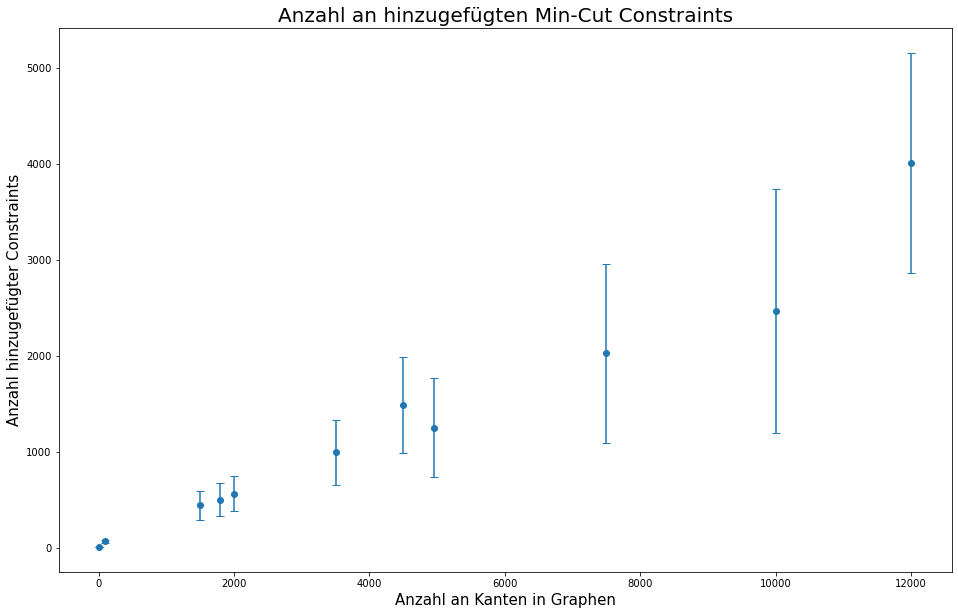

In [15]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(e, m_c)
ax.set_title("Anzahl an hinzugefügten Min-Cut Constraints", fontsize=20)
ax.set_xlabel("Anzahl an Kanten in Graphen", fontsize=15)
ax.set_ylabel("Anzahl hinzugefügter Constraints", fontsize=15)
ax.errorbar(e, m_c, s_c, fmt='None', capsize=4)

<ErrorbarContainer object of 3 artists>

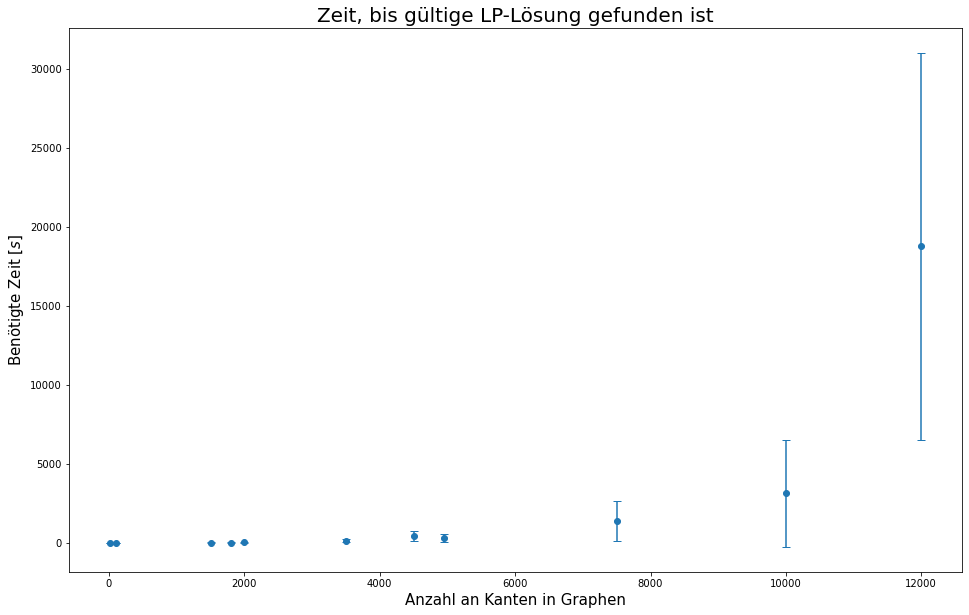

In [16]:
fig, ax = plt.subplots(figsize=(16,10))
# ax.scatter(e, m_loop)
ax.set_title("Zeit, bis gültige LP-Lösung gefunden ist", fontsize=20)
ax.set_xlabel("Anzahl an Kanten in Graphen", fontsize=15)
ax.set_ylabel("Benötigte Zeit [$s$]", fontsize=15)
ax.errorbar(e, m_loop, s_loop, fmt='o', capsize=4)

## Fitten

In [149]:
# linearer fit:
def f_lin(x, m, n):
    return m * x + n

# exponentieller Fit:
def f_exp(x, a, b):
    return a * np.exp(b *x)

In [109]:
popt_lin, pcov_lin = curve_fit(f_lin, e, m_c)
popt_lin

array([  0.29578979, -27.44718156])

In [119]:
e

[10, 100, 1500, 1800, 2000, 3500, 4500, 4950, 7500, 10000, 12000]

In [120]:
m_loop

[0.0,
 0.0,
 10.70754716981132,
 16.926829268292682,
 23.386666666666667,
 140.375,
 425.875,
 313.875,
 1412.5438596491229,
 3126.12,
 18791.25]

In [151]:
popt_exp, pcov_exp = curve_fit(f_exp, e, m_loop, maxfev=50000, p0=[0,0])#, bounds=([-500, 0, -50], [500, 10, 50]))
popt_exp

array([0.69420596, 0.00085037])

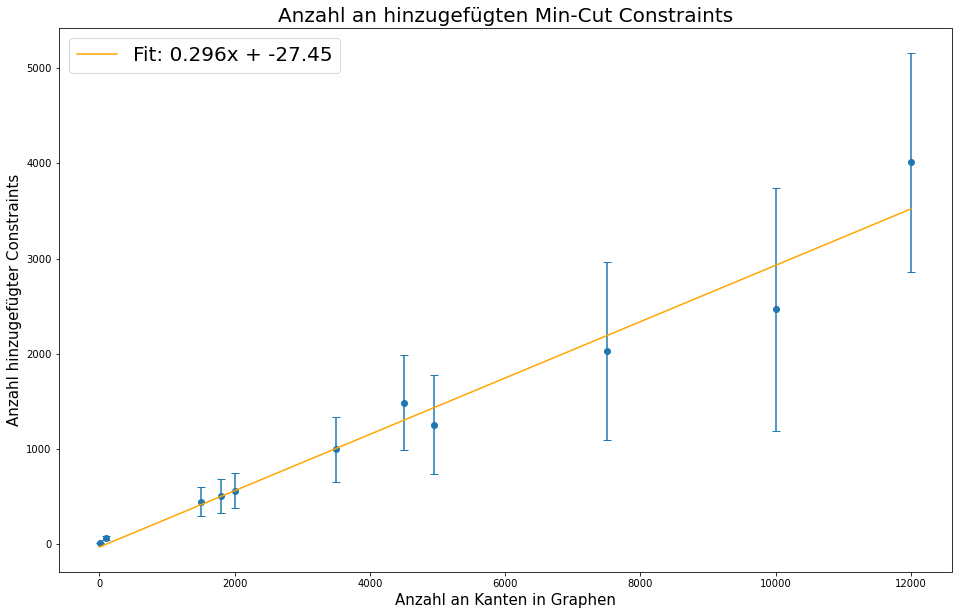

In [152]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(e, m_c)
ax.set_title("Anzahl an hinzugefügten Min-Cut Constraints", fontsize=20)
ax.set_xlabel("Anzahl an Kanten in Graphen", fontsize=15)
ax.set_ylabel("Anzahl hinzugefügter Constraints", fontsize=15)
ax.errorbar(e, m_c, s_c, fmt='None', capsize=4)

lp = np.linspace(0, 12000, 100)

ax.plot(lp, f_lin(lp, *popt_lin), c='orange', label=f"Fit: {popt_lin[0]:.3}x + {popt_lin[1]:.4}")
ax.legend(fontsize=20)

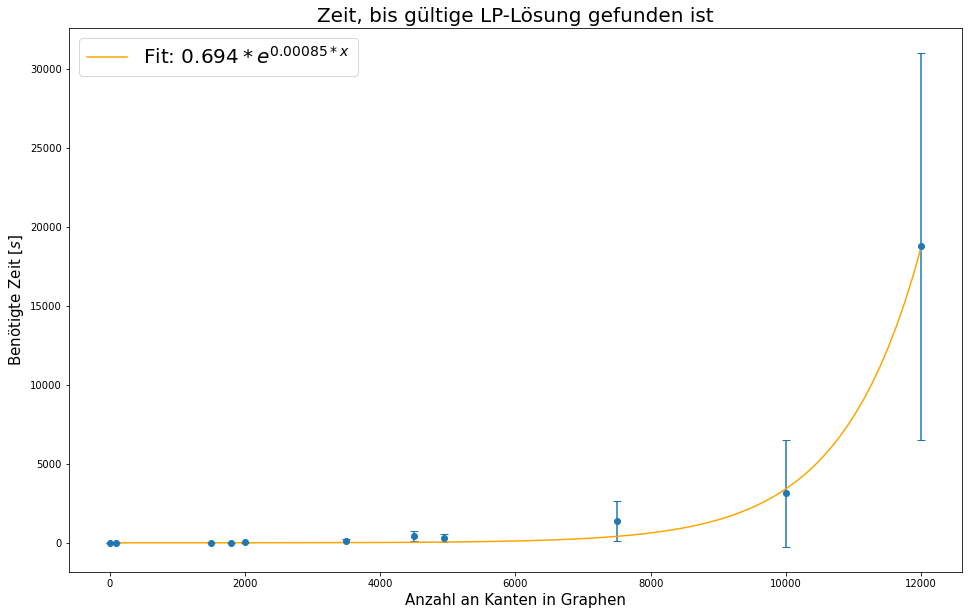

In [162]:
fig, ax = plt.subplots(figsize=(16,10))
# ax.scatter(e, m_loop)
ax.set_title("Zeit, bis gültige LP-Lösung gefunden ist", fontsize=20)
ax.set_xlabel("Anzahl an Kanten in Graphen", fontsize=15)
ax.set_ylabel("Benötigte Zeit [$s$]", fontsize=15)
ax.errorbar(e[:], m_loop[:], s_loop[:], fmt='o', capsize=4)

lp = np.linspace(0, 12000, 100)

ax.plot(lp, f_exp(lp, *popt_exp), c='orange', label=f"Fit: ${popt_exp[0]:.3} * e^{{{popt_exp[1]:.3} * x}}$")
ax.legend(fontsize=20)


## Meine opt-Zeiten sind useless, weil darin aus Versehen nochmal die Setup-Zeiten gespeichert wurden.

Ich kann also nicht sagen, ob der LP-Alg der Teil ist, der exponentiell länger benötigt

Wenn ich gute opt Zeiten hätte, könnte ich einmal schauen, wie die sich von Iteration zu Iteration ändern und außerdem könnte ich schauen, wie die sich unterscheiden, wenn die Problemstellung größer wird.

In [26]:
# so viele Minuten dauerten die 8 4500er Simulationen
sum(loop_zeiten[-1]/60)

56.78333333333333

In [37]:
for i, l in enumerate(loop_zeiten):
    print(f"{number_edges[i]} Kanten: {len(l)} Simulationen in {sum(l/60):.2f} Minuten (entspricht {mean_loop_zeiten[i]:.2f}s/Simulation)")

1500 Kanten: 318 Simulationen in 56.75 Minuten (entspricht 10.71s/Simulation)
1800 Kanten: 205 Simulationen in 57.83 Minuten (entspricht 16.93s/Simulation)
2000 Kanten: 150 Simulationen in 58.47 Minuten (entspricht 23.39s/Simulation)
4500 Kanten: 8 Simulationen in 56.78 Minuten (entspricht 425.88s/Simulation)


# Jetzt neu mit der aktualisierten Version des LP-Algs

In [19]:
e2, m_c2, s_c2 = do_counters(d_neu)
e2, m_loop2, s_loop2 = do_loop_times(d_neu)
e10, m_c10, s_c10 = do_counters(d_neu, 10)
e10, m_loop10, s_loop10 = do_loop_times(d_neu, 10)

<ErrorbarContainer object of 3 artists>

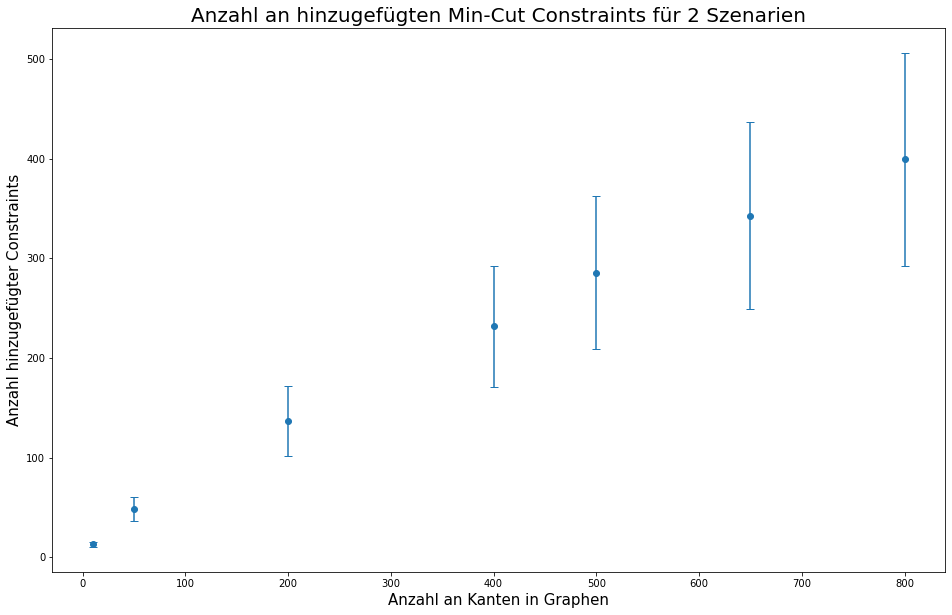

In [18]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(e2, m_c2)
ax.set_title("Anzahl an hinzugefügten Min-Cut Constraints für 2 Szenarien", fontsize=20)
ax.set_xlabel("Anzahl an Kanten in Graphen", fontsize=15)
ax.set_ylabel("Anzahl hinzugefügter Constraints", fontsize=15)
ax.errorbar(e2, m_c2, s_c2, fmt='None', capsize=4)

<ErrorbarContainer object of 3 artists>

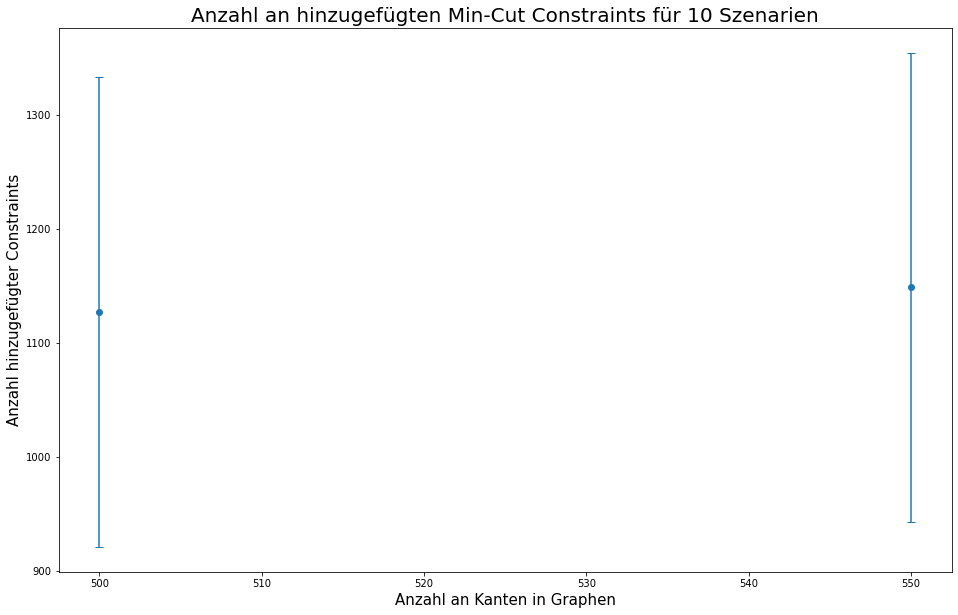

In [20]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(e10, m_c10)
ax.set_title("Anzahl an hinzugefügten Min-Cut Constraints für 10 Szenarien", fontsize=20)
ax.set_xlabel("Anzahl an Kanten in Graphen", fontsize=15)
ax.set_ylabel("Anzahl hinzugefügter Constraints", fontsize=15)
ax.errorbar(e10, m_c10, s_c10, fmt='None', capsize=4)

### Zeit

<ErrorbarContainer object of 3 artists>

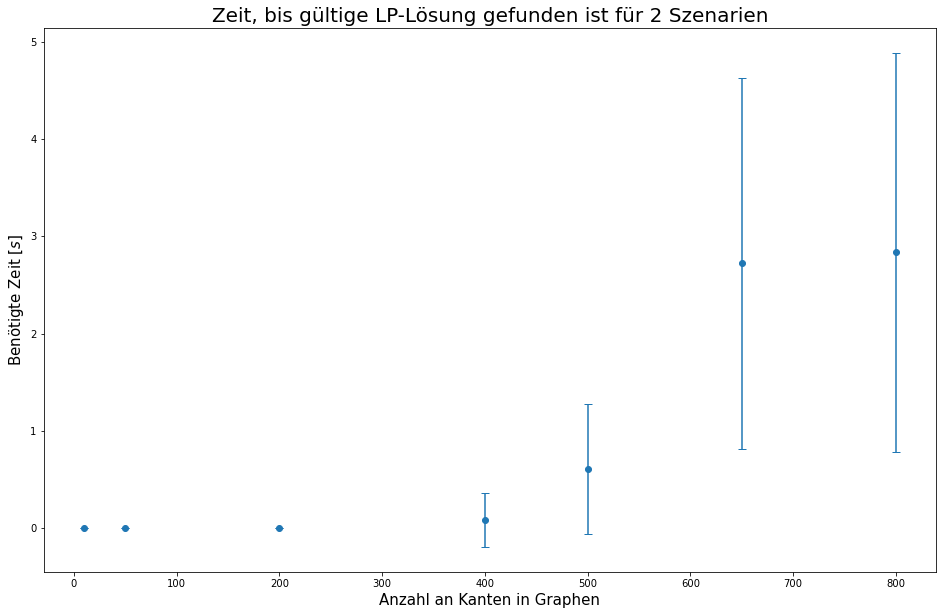

In [21]:
fig, ax = plt.subplots(figsize=(16,10))
ax.set_title("Zeit, bis gültige LP-Lösung gefunden ist für 2 Szenarien", fontsize=20)
ax.set_xlabel("Anzahl an Kanten in Graphen", fontsize=15)
ax.set_ylabel("Benötigte Zeit [$s$]", fontsize=15)
ax.errorbar(e2, m_loop2, s_loop2, fmt='o', capsize=4)

<ErrorbarContainer object of 3 artists>

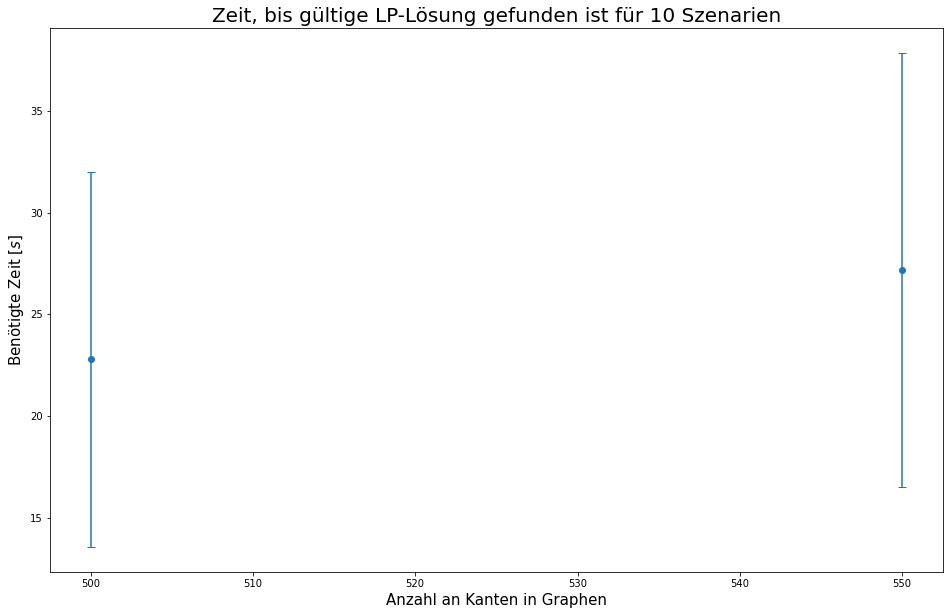

In [22]:
fig, ax = plt.subplots(figsize=(16,10))
ax.set_title("Zeit, bis gültige LP-Lösung gefunden ist für 10 Szenarien", fontsize=20)
ax.set_xlabel("Anzahl an Kanten in Graphen", fontsize=15)
ax.set_ylabel("Benötigte Zeit [$s$]", fontsize=15)
ax.errorbar(e10, m_loop10, s_loop10, fmt='o', capsize=4)

# Jetzt will ich rausfinden, welcher Teil vom LP-Alg so lange dauert

In [24]:
pt = r"D:\Uni\Masterarbeit\Daten\LP_Tracking"

In [129]:
def load_tracking_files(p):
    """
    p ist pfad zu einer simulation_x
    
    """
    pt = os.path.join(p, "Tracking")
    pt_opt = os.path.join(pt, "opt")
#     print(pt_opt)
    
    df = pd.DataFrame()
    
    df['counters'] = np.loadtxt(os.path.join(pt, "counters.txt"), dtype=int)
    df['setup'] = np.loadtxt(os.path.join(pt, "setup_zeiten_s.txt"), dtype=int)
    df['loop'] = np.loadtxt(os.path.join(pt, "loop_zeiten_s.txt"), dtype=int)
    df['total'] = np.loadtxt(os.path.join(pt, "total.txt")) / 1000
    
    opt = [np.loadtxt(os.path.join(pt_opt, i)) for i in sorted(os.listdir(pt_opt), key=lambda x: int(x.split("_")[0]))]
    
    sums = [sum(i)/1000 for i in opt]
    
    df['Summe Opt'] = sums
#     d_f = {'counters': counters, 'setup_zeiten': setup, 'loop_zeiten': loop, 'total': total, 'opt': opt}
    
    return df

In [86]:
d50a = load_tracking_files(r"D:\Uni\Masterarbeit\Daten\LP_Tracking\TimeTest_50_nodes_10_scenarios\TreePlusP_0.000000_p_50_nodes_10_RandomScenarioCreator_RandomTestCreator_0.000000_10.000000\simulation_0")
# d80 = load_tracking_files(r"D:\Uni\Masterarbeit\Daten\LP_Tracking\TimeTest_80_nodes_10_scenarios\TreePlusP_0.000000_p_80_nodes_10_RandomScenarioCreator_RandomTestCreator_0.000000_10.000000\simulation_1")

In [87]:
(d50a['Summe Opt'] / d50a['total']).mean()

0.41786803918775584

In [92]:
d50.mean().counters

2664.998

## Auswertung

Es kommt selten mal vor, dass die komplette (totale) Laufzeit des LP minimal länger war, als die Zeit, die das while-loop gebraucht hat. Das kommt bei 80 Knoten häufiger vor als bei 50.

### Wie viel Prozent der Gesamtlaufzeit machen die Gurobi-Optimierungen aus

Ein anderer Teil der Zeit kosten kann ist das hinzufügen von neuen Bedingungen.

Wann werden wie viele Bedingungen im Durchschnitt hinzugefügt?

In [ ]:
# ich muss für alle Simulationen pro Konfiguration ein Dataframe ueber alle simulation_x Ordner machen, daraus dann
# die Anteile berechnen und das dann plotten

In [102]:
def read_tracking_files(konfig_path):
    """
    Ist dafuer da, fuer eine Konfiguration ueber alle Simulationen zu gehen und die Trackingdaten in ein einziges
    Dataframe zu packen
    """
    
    # muss erstmal rausfinden, welche Simulationen alle gemacht wurden
    sims = os.listdir(konfig_path)
    
    # erstes Dataframe von simulation_0
    df = load_tracking_files(os.path.join(konfig_path, sims[0]))
    
    # die restlichen simulation_x Ordner einlesen und an das DataFrame dranpacken
    for sim in sims[1:]:

        df_sim = load_tracking_files(os.path.join(konfig_path, sim))
        df = pd.concat([df, df_sim], ignore_index=True)
    
    return df

In [117]:
def get_konfigs(ueber_path):
    """
    Ist dafuer da, fuer einen Ueberordner alle Trackingdaten der Konfigurationen (Variable ist hier p) in eine plotbare Form
    zu bringen
    
    dazu gebe ich ein DataFrame zurueck, wo 
    """
    
    # jetzt alle Ergebnisse einlesen
    konfigs = os.listdir(ueber_path)
    
    # dictionary, was mir fuer die verschiedenen Simulationen den Index zum relevanten Parameter gibt
    # Fuer TreePlusP, ist hier die Wahrscheinlichkeit p relevant
    d = {"TreePlusP": 1}
    ps = [float(k.split("_")[d[k.split("_")[0]]]) for k in konfigs]
    dfs = [read_tracking_files(os.path.join(ueber_path, k)) for k in konfigs]
    
    df_res = pd.DataFrame()
    df_res['p'] = ps
    
    # jetzt Daten verarbeiten
    # mittlere Anzahl an Iterationen
    mean_its = [df.mean().counters for df in dfs]
    df_res['m_iterations'] = mean_its
    
    # mittlerer totale Laufzeit in s
    df_res['m_total'] = [df.mean().total for df in dfs]
    
    # mittlerer Anteil von den Gurobioptimierungsschritten an Gesamtlaufzeit
    df_res['anteil_opt'] = [(df['Summe Opt'] / df['total']).mean() for df in dfs]
    
    return df_res

In [130]:
d = get_konfigs(r"D:\Uni\Masterarbeit\Daten\LP_Tracking\TimeTest_10_nodes_10_scenarios")

In [132]:
d

,p,m_iterations,m_total,anteil_opt
0,0.00,147.559,0.066372,0.221130
1,0.05,147.228,0.075978,0.246673
2,0.10,152.228,0.085792,0.266769
3,0.15,155.932,0.093068,0.279953
4,0.20,158.496,0.099335,0.291673
5,0.25,163.798,0.106839,0.300531
6,0.30,163.808,0.111663,0.307334
7,0.35,166.034,0.116273,0.312943
8,0.40,168.080,0.121634,0.318625
9,0.45,167.364,0.124425,0.322675


## Das jetzt fuer alle Simulationen machen und plotten

In [139]:
# Daten einlesen (extra, weil dauert lange, also mehrere Minuten)
p = r"D:\Uni\Masterarbeit\Daten\LP_Tracking"

data = {s: get_konfigs(os.path.join(p, s)) for s in os.listdir(p)}

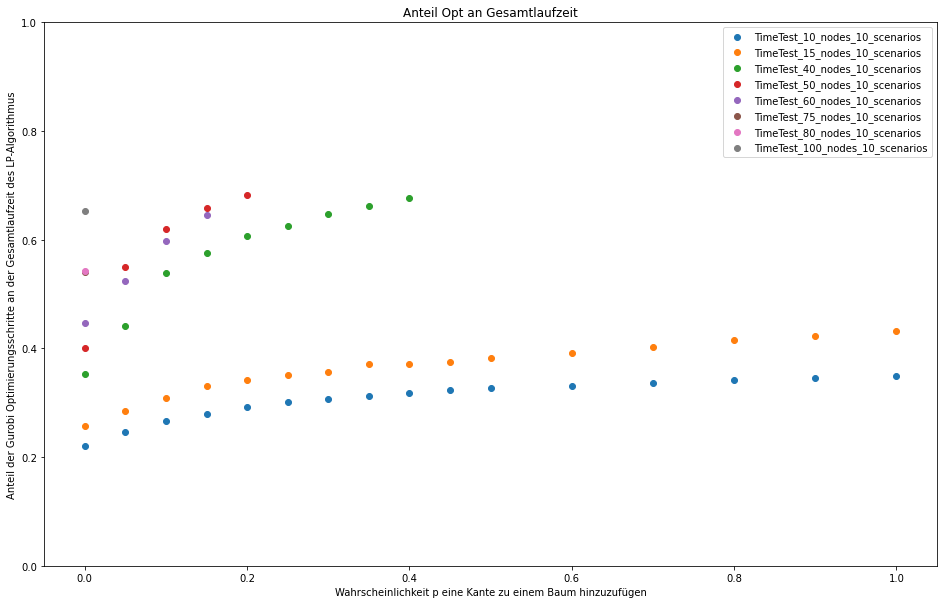

In [155]:
# plotten
fig, ax = plt.subplots(figsize=(16, 10))

for s in sorted(data, key=lambda x: int(x.split("_")[1])):
#     if not "50" in s:
    ax.scatter(data[s]['p'], data[s]['anteil_opt'], label=s)
ax.set_ylim([0,1])
ax.set_title("Anteil Opt an Gesamtlaufzeit")
ax.set_xlabel("Wahrscheinlichkeit p eine Kante zu einem Baum hinzuzufügen")
ax.set_ylabel("Anteil der Gurobi Optimierungsschritte an der Gesamtlaufzeit des LP-Algorithmus")
ax.legend()

# Auswertung
Der Anteil der Gurobi-Optimierungsschritte an der Gesamtzeit wächst mit höherer Kantenanzahl und ist für Graphen mit mehr Knoten größer. Also: Je mehr Kanten und v.A. je mehr Knoten es gibt, desto höher wird der Anteil der Optimierungsschritte an der Gesamtlaufzeit des LP-Algorithmus. Da kann ich also für größere Problemstellungen nicht mehr viel optimieren, wenn ich bei Gruobi bleiben will und das will ich. Was auffällt ist, dass für kleine p der Anteil bei 50 Knoten größer ist als bei 60. Keine Ahnung woran das liegt. Denn es werden bei 60 Knoten durchschnittlich mehr Constraints benötigt und insgesammt braucht der Algorithmus auch länger bei 60 Knoten. Aus irgendeinem Grund ist der Gurobi-Alg. da aber anscheinend schneller. 

Der Rest der Laufzeit ist dann der Teil, wo ich schaue, ob für alle Szenarien die Min-Cut Bedingung erfüllt ist und das Hinzufügen neuer Bedingungen, falls die Bedingung nicht erfüllt ist.

In [1]:
# plotten
fig, ax = plt.subplots(figsize=(16, 10))

for s in sorted(data, key=lambda x: int(x.split("_")[1])):
#     if not "50" in s:
    ax.scatter(data[s]['p'], data[s]['m_iterations'], label=s)
ax.set_title("Durchschnittliche Anzahl an hinzugefügten Constraints")
ax.set_ylabel("Anzahl Constraints")
ax.set_xlabel("p")
ax.legend()

NameError: name 'plt' is not defined

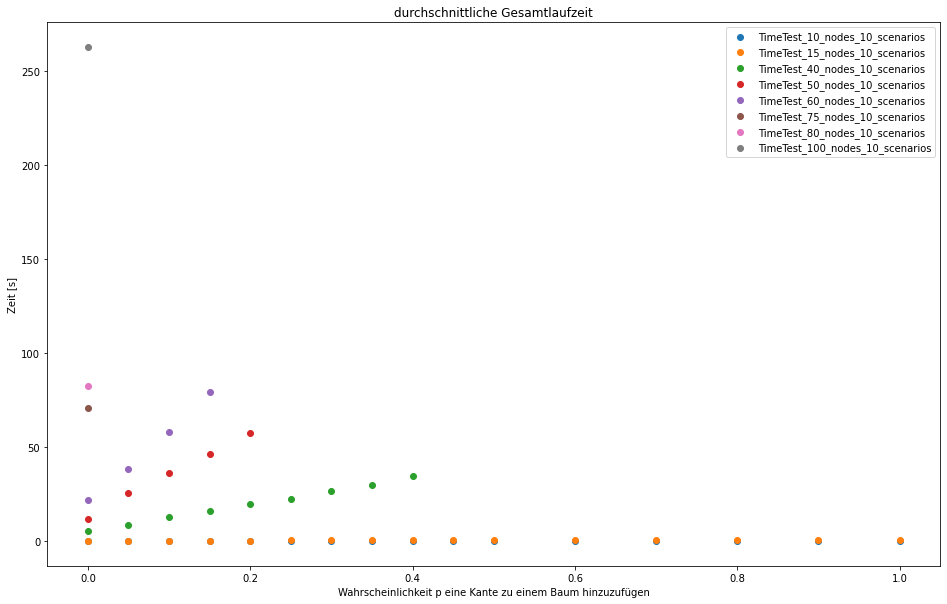

In [157]:
# plotten
fig, ax = plt.subplots(figsize=(16, 10))

for s in sorted(data, key=lambda x: int(x.split("_")[1])):
#     if not "50" in s:
    ax.scatter(data[s]['p'], data[s]['m_total'], label=s)
ax.set_title("durchschnittliche Gesamtlaufzeit")
ax.set_xlabel("Wahrscheinlichkeit p eine Kante zu einem Baum hinzuzufügen")
ax.set_ylabel("Zeit [s]")
ax.legend()

## 2 Szenarien

In [147]:
# Daten einlesen (extra, weil dauert lange, also mehrere Minuten)
p2 = r"D:\Uni\Masterarbeit\Daten\LP_Tracking\2_scen"

data2 = {s: get_konfigs(os.path.join(p2, s)) for s in os.listdir(p2)}

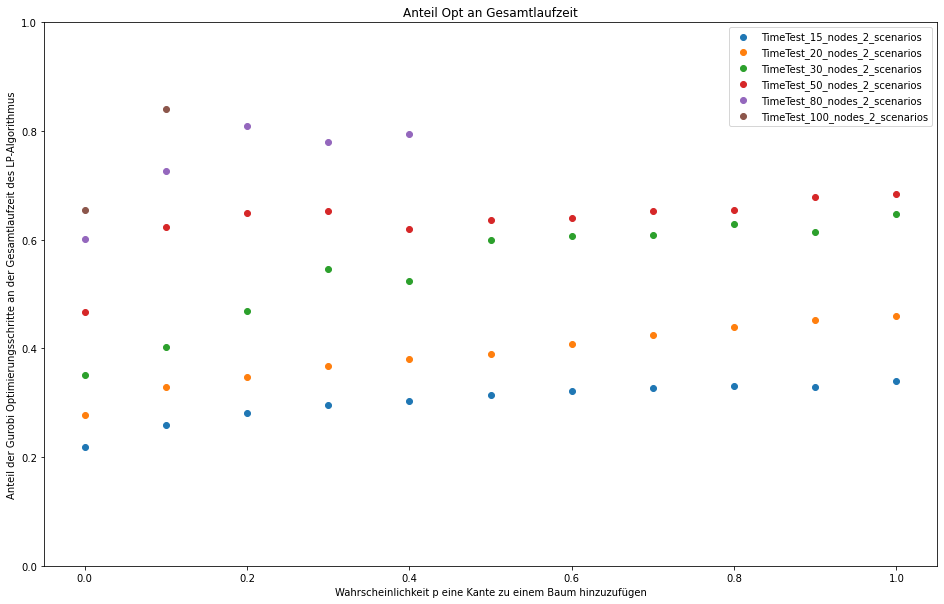

In [152]:
# plotten
fig, ax = plt.subplots(figsize=(16, 10))

for s in sorted(data2, key=lambda x: int(x.split("_")[1])):
#     if not "50" in s:
    ax.scatter(data2[s]['p'], data2[s]['anteil_opt'], label=s)
ax.set_ylim([0,1])
ax.set_title("Anteil Opt an Gesamtlaufzeit")
ax.set_xlabel("Wahrscheinlichkeit p eine Kante zu einem Baum hinzuzufügen")
ax.set_ylabel("Anteil der Gurobi Optimierungsschritte an der Gesamtlaufzeit des LP-Algorithmus")
ax.legend()

Auch für nur 2 Szenarien machen die Gurobi-Optimierungsschritte einen großen Teil der Gesamtlaufzeit aus.

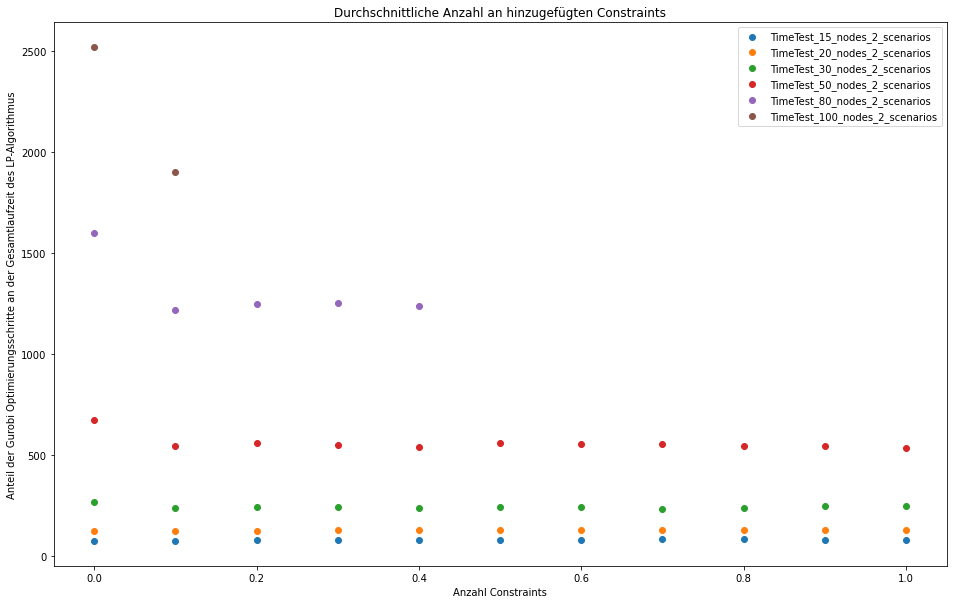

In [153]:
# plotten
fig, ax = plt.subplots(figsize=(16, 10))

for s in sorted(data2, key=lambda x: int(x.split("_")[1])):
#     if not "50" in s:
    ax.scatter(data2[s]['p'], data2[s]['m_iterations'], label=s)
ax.set_title("Durchschnittliche Anzahl an hinzugefügten Constraints")
ax.set_xlabel("Anzahl Constraints")
ax.set_ylabel("Anteil der Gurobi Optimierungsschritte an der Gesamtlaufzeit des LP-Algorithmus")
ax.legend()

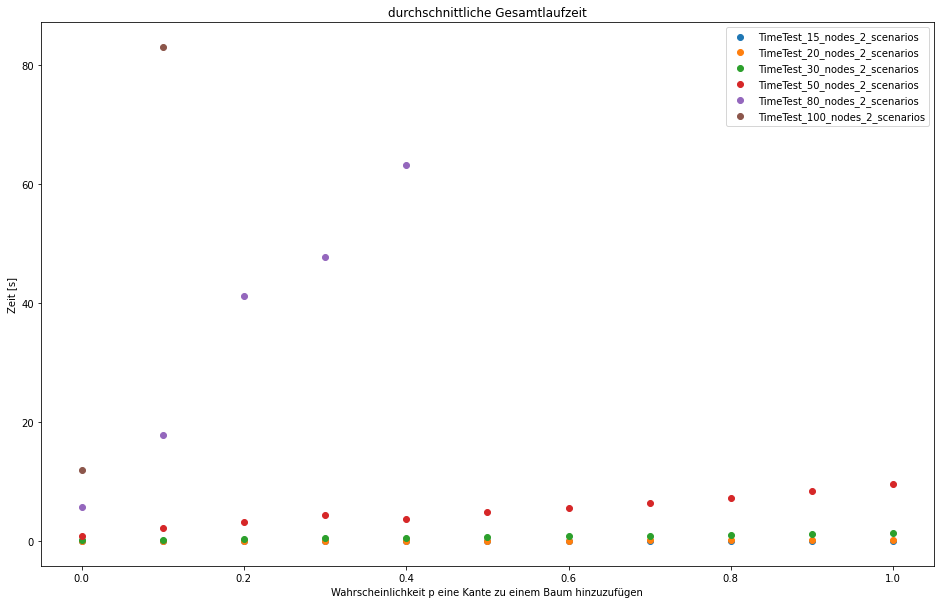

In [154]:
# plotten
fig, ax = plt.subplots(figsize=(16, 10))

for s in sorted(data2, key=lambda x: int(x.split("_")[1])):
#     if not "50" in s:
    ax.scatter(data2[s]['p'], data2[s]['m_total'], label=s)
ax.set_title("durchschnittliche Gesamtlaufzeit")
ax.set_xlabel("Wahrscheinlichkeit p eine Kante zu einem Baum hinzuzufügen")
ax.set_ylabel("Zeit [s]")
ax.legend()

Für bis zu 50 Knoten wächst die Gesamtlaufzeit für den LP-Alg nicht so schnell für größere p an, aber für 80 dann schon schneller. Ist aber auch verständlich, weil mit mehr Knoten auch immer mehr potentielle Kanten dazu kommen. Vielleicht gibt es da eine gewissen Knotenanzahl ab der das stark steigt?

# Und jetzt?
Ich will nen Phasenübergang sehen!